In [33]:
# add necessary libraries for accessing and manipulating data
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
species = pd.read_csv('species_info.csv')
print("SPECIES TABLE DESCRIPTION")
print(species.describe())
print("\nSPECIES TABLE INFORMATION")
print(species.info())
print("\nSPECIES TABLE FIRST ROWS")
print(species.head())
present_cons_status = species[~species.conservation_status.isnull()]
print(species[~species.conservation_status.isnull()].groupby('conservation_status').common_names.count())
print(present_cons_status.head())

SPECIES TABLE DESCRIPTION
              category    scientific_name        common_names  \
count             5824               5824                5824   
unique               7               5541                5504   
top     Vascular Plant  Castor canadensis  Brachythecium Moss   
freq              4470                  3                   7   

       conservation_status  
count                  191  
unique                   4  
top     Species of Concern  
freq                   161  

SPECIES TABLE INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             5824 non-null   object
 1   scientific_name      5824 non-null   object
 2   common_names         5824 non-null   object
 3   conservation_status  191 non-null    object
dtypes: object(4)
memory usage: 182.1+ KB
None

SPECIES TABLE FIRST ROWS
  c

In [4]:
# Alright, let's take a look at the observations data
observations = pd.read_csv('observations.csv')
print("OBSERVATION TABLE DESCRIPTION")
print(observations.describe())
print("\nOBSERVATION TABLE INFORMATION")
print(observations.info())
print("\nOBSERVATION TABLE FIRST ROWS")
print(observations.head())
print(observations.nunique())

OBSERVATION TABLE DESCRIPTION
       observations
count  23296.000000
mean     142.287904
std       69.890532
min        9.000000
25%       86.000000
50%      124.000000
75%      195.000000
max      321.000000

OBSERVATION TABLE INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23296 entries, 0 to 23295
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scientific_name  23296 non-null  object
 1   park_name        23296 non-null  object
 2   observations     23296 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 546.1+ KB
None

OBSERVATION TABLE FIRST ROWS
            scientific_name                            park_name  observations
0        Vicia benghalensis  Great Smoky Mountains National Park            68
1            Neovison vison  Great Smoky Mountains National Park            77
2         Prunus subcordata               Yosemite National Park           138
3      Abutilon theophr

In [5]:
# Okay, so looking at the above, I'm seeing that the datatypes for all columns across both tables look reasonable to me.
# No missing data from the observations table, so that's lovely
# There are NOT a lot of conservation statuses in the species table. Let's just look up what the possible
# conservation statuses are. Weird that we have a lot of null knowing what the levels are.

In [6]:
#Okay, so I've done some more research into the data provided. I believe that the species table pulled the conservation
# status from the US Fish and Wildlife's website which has a table that can be downloaded as a csv file. This table only
# contains species that are currently endangered, experimental population (non-essential), similarity of appearance to 
# a threatened taxon, and threatened 

In [7]:
# So my conclusion is that a lot of the species that were spotted and reported in the 4 national parks in the observations table,
# are not classified as one of that statuses available, probably because they are least concern or something that's doing ok.
# Therefore, since the data is important only for species that are at risk, I'll only be looking at the species that have
# a non-null value for the conservation status.

In [8]:
# Now, the goal is going to be to take species with a conservation status, and grab the info of just those species
# from the observations table, and combine that with what we know from the convservation status. That's doable.

In [9]:
# what I would like the final table to look like:
# category, genus, epithet, common name, status, park1, park2, park3, park4, total observations
#                                                #obs   #obs   #obs   #obs

In [10]:
print(present_cons_status.head())
print(len(present_cons_status))

   category            scientific_name       common_names conservation_status
7    Mammal              Canis latrans             Coyote  Species of Concern
8    Mammal                Canis lupus          Gray Wolf          Endangered
9    Mammal                Canis rufus           Red Wolf          Endangered
29   Mammal           Eptesicus fuscus      Big Brown Bat  Species of Concern
30   Mammal  Lasionycteris noctivagans  Silver-Haired Bat  Species of Concern
191


In [11]:
# trim down observation data to only include the 191 species present in present_cons_status
conservation_observations = observations[observations['scientific_name'].isin(present_cons_status['scientific_name'])]
grouped = conservation_observations.groupby(['scientific_name', 'park_name']).nunique()
print(len(conservation_observations.groupby('scientific_name').nunique()))
#print(grouped[grouped.observations > 1])
print(conservation_observations[conservation_observations.scientific_name == 'Canis lupus'])
# So 179 species are in the observations table that also have conservation statuses in the species table
# some species/park combos have more than 1 observation/entry, so will need to account for that

179
      scientific_name                            park_name  observations
1294      Canis lupus               Yosemite National Park            35
1766      Canis lupus                  Bryce National Park            27
7346      Canis lupus                  Bryce National Park            29
9884      Canis lupus                  Bryce National Park            74
10190     Canis lupus  Great Smoky Mountains National Park            15
10268     Canis lupus            Yellowstone National Park            60
10907     Canis lupus            Yellowstone National Park            67
13427     Canis lupus            Yellowstone National Park           203
17756     Canis lupus  Great Smoky Mountains National Park            14
19330     Canis lupus               Yosemite National Park           117
19987     Canis lupus               Yosemite National Park            44
20353     Canis lupus  Great Smoky Mountains National Park            30


In [12]:
#if we have more than 2 words for the scientific name that's ok. 1st word = genus, others = species (subspecies, variety)
#columns for genus_species should include, scientific_name, category, common_names, conservation_status, genus, species
genus_species = pd.DataFrame()
genus_species[['genus', 'species']] = present_cons_status['scientific_name'].str.split(' ', n=1, expand=True)
present_cons_status = pd.concat([present_cons_status, genus_species], axis=1) # keep non-expanded scientific name for merge

In [13]:
print(present_cons_status.info())
print(present_cons_status.scientific_name.nunique())
# remove entries with matching scientific name and conservation status
unique_scientific_name_cons_status = present_cons_status.drop_duplicates(subset=['scientific_name', 'conservation_status'])
#I know that we still have a duplicate of the gray wolf. it has two different conservation statuses.
# So, how do I know who to keep? In Recovery is not an official status, so I will remove that one from the duplicate
unique_scientific_name_cons_status = unique_scientific_name_cons_status.drop_duplicates(subset='scientific_name')
print(len(unique_scientific_name_cons_status))

<class 'pandas.core.frame.DataFrame'>
Index: 191 entries, 7 to 5676
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             191 non-null    object
 1   scientific_name      191 non-null    object
 2   common_names         191 non-null    object
 3   conservation_status  191 non-null    object
 4   genus                191 non-null    object
 5   species              191 non-null    object
dtypes: object(6)
memory usage: 10.4+ KB
None
179
179


In [14]:
# Columns for the new observation table will need to be: 
# scientific_name, yosemite, bryce, great_smoky_mountains, yellowstone, total observations
print(conservation_observations.head())
duplicated = conservation_observations.drop_duplicates(ignore_index=True)
print(len(duplicated))
observations_counted = conservation_observations.groupby(['scientific_name', 'park_name']).observations.sum().reset_index()
print(len(observations_counted))
# lovely, now we should be able to pivot the table and then apply a lambda function to give us the total observation column
observe_pivot = observations_counted.pivot(index='scientific_name', columns='park_name', values='observations')
print(observe_pivot.info())
observe_pivot['total_observations'] = observe_pivot.apply(lambda row: row['Bryce National Park'] + row['Great Smoky Mountains National Park'] + row['Yellowstone National Park'] + row['Yosemite National Park'], axis=1)
print(observe_pivot.info())

                              scientific_name  \
24                           Zizia trifoliata   
36           Camissonia sierrae ssp. alticola   
71                           Tofieldia glabra   
94                         Accipiter cooperii   
118  Dichanthelium acuminatum var. acuminatum   

                               park_name  observations  
24                Yosemite National Park           135  
36                   Bryce National Park            84  
71   Great Smoky Mountains National Park            75  
94                   Bryce National Park            95  
118               Yosemite National Park           123  
768
716
<class 'pandas.core.frame.DataFrame'>
Index: 179 entries, Abies fraseri to Zizia trifoliata
Data columns (total 4 columns):
 #   Column                               Non-Null Count  Dtype
---  ------                               --------------  -----
 0   Bryce National Park                  179 non-null    int64
 1   Great Smoky Mountains National Par

In [27]:
#alrighty, based on info outputs, we have our two tables set up to merge in the way I want them to.
# I also don't see any missing data between the two tables. We are, on the following merge, going to 
# combine our tables with an inner merge on the scientific_name column - meaning that we will lose some of the
# entries from the species table - but since we don't have observation data related to those species, that data won't help
final_table = unique_scientific_name_cons_status.merge(observe_pivot, how='inner', on='scientific_name')
final_table = final_table.rename({'Bryce National Park': 'Bryce', 'Great Smoky Mountains National Park': 'Smoky', 'Yellowstone National Park': 'Yellowstone', 'Yosemite National Park': 'Yosemite'}, axis='columns')
print(final_table.info()) # Got the data I need
print(final_table.describe())
print(final_table.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             179 non-null    object
 1   scientific_name      179 non-null    object
 2   common_names         179 non-null    object
 3   conservation_status  179 non-null    object
 4   genus                179 non-null    object
 5   species              179 non-null    object
 6   Bryce                179 non-null    int64 
 7   Smoky                179 non-null    int64 
 8   Yellowstone          179 non-null    int64 
 9   Yosemite             179 non-null    int64 
 10  total_observations   179 non-null    int64 
dtypes: int64(5), object(6)
memory usage: 15.5+ KB
None
            Bryce       Smoky  Yellowstone    Yosemite  total_observations
count  179.000000  179.000000   179.000000  179.000000          179.000000
mean    90.854749   63.000000   218.072626  131.4692

<Axes: title={'center': 'Category by Conservation Status'}, xlabel='Conservation Status', ylabel='Number of species'>

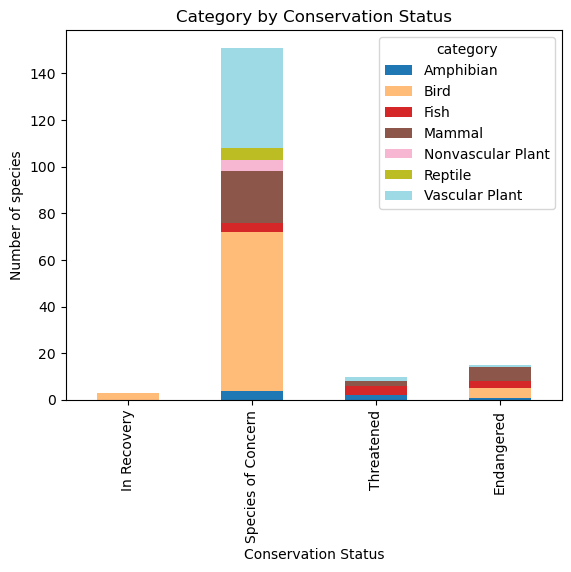

In [52]:
# now I can start making pretty graphs
conservation_statuses = final_table.groupby(['conservation_status', 'category']).category.count().unstack()
ordered_statuses = ['In Recovery', 'Species of Concern', 'Threatened', 'Endangered']
conservation_statuses.loc[ordered_statuses].plot(kind='bar', stacked=True, colormap='tab20', title='Category by Conservation Status', ylabel='Number of species', xlabel='Conservation Status')

<Axes: title={'center': 'Conservation Status by Genus'}, xlabel='Conservation Status', ylabel='Number of Species'>

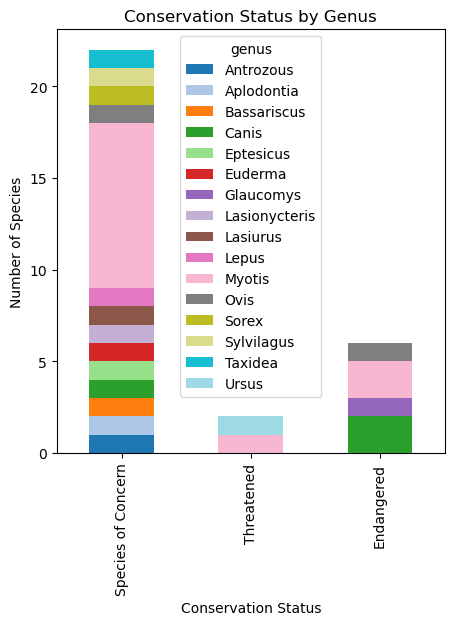

In [57]:
mammals = final_table[final_table['category'] == 'Mammal']
conservation_status_observations = mammals.groupby(['conservation_status', 'genus']).species.count().unstack()
ordered_status = ['Species of Concern', 'Threatened', 'Endangered']
conservation_status_observations.loc[ordered_status].plot(kind='bar', stacked=True, colormap='tab20', title='Conservation Status by Genus', ylabel='Number of Species', xlabel="Conservation Status", figsize=(5, 5.5))

category             Amphibian     Bird   Fish  Mammal  Nonvascular Plant  \
conservation_status                                                         
Endangered                60.0    243.0  202.0   660.0                NaN   
In Recovery                NaN    559.0    NaN     NaN                NaN   
Species of Concern       852.0  15986.0  955.0  6302.0             1169.0   
Threatened               255.0      NaN  718.0   258.0                NaN   

category             Reptile  Vascular Plant  
conservation_status                           
Endangered               NaN            63.0  
In Recovery              NaN             NaN  
Species of Concern    1100.0          9425.0  
Threatened               NaN           228.0  


<Axes: title={'center': 'Number of Observations by Conservation Status and Category'}, xlabel='conservation_status', ylabel='Number of Observations'>

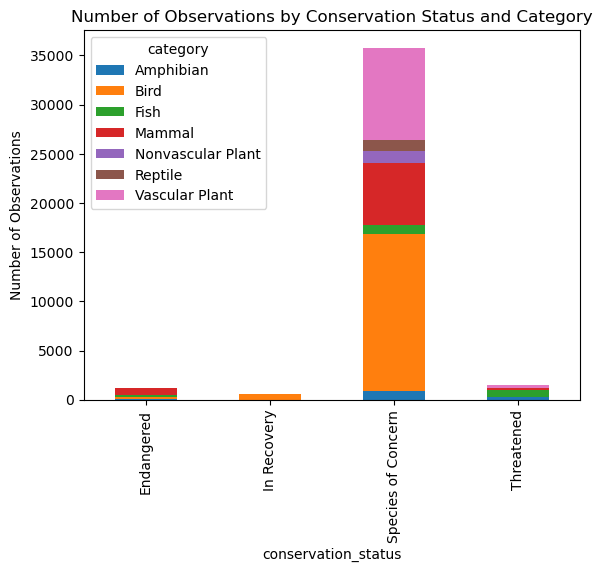

In [50]:
observation_by_category_yellowstone = final_table.groupby(['conservation_status', 'category']).Yellowstone.sum().unstack()
print(observation_by_category_yellowstone)
observation_by_category_yellowstone.plot(stacked=True, kind='bar', title='Number of Observations by Conservation Status and Category', ylabel="Number of Observations")

<Axes: title={'center': 'Bryce Observations by Category'}>

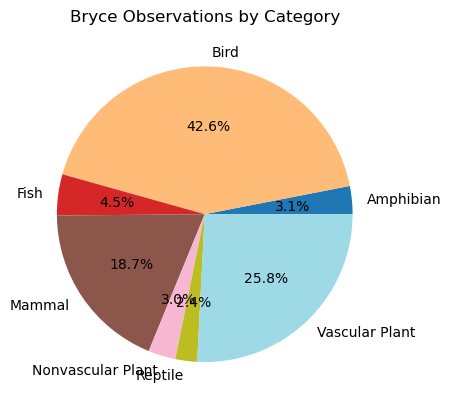

In [63]:
# I'd like some pie charts (one per park that breaks down the number of observations by category as percentages)
# don't have to calculate the percentages for the pie chart function, but do need to sum up by category
bryce_observations_by_category = final_table.groupby('category').Bryce.sum()
yellowstone_observations_by_category = final_table.groupby('category').Yellowstone.sum()
yosemite_observations_by_category = final_table.groupby('category').Yosemite.sum()
smoky_observations_by_category = final_table.groupby('category').Smoky.sum()
bryce_observations_by_category.plot(kind='pie', title='Bryce Observations by Category', ylabel='', autopct='%1.1f%%', colormap='tab20')

<Axes: title={'center': 'Yellowstone Observations by Category'}>

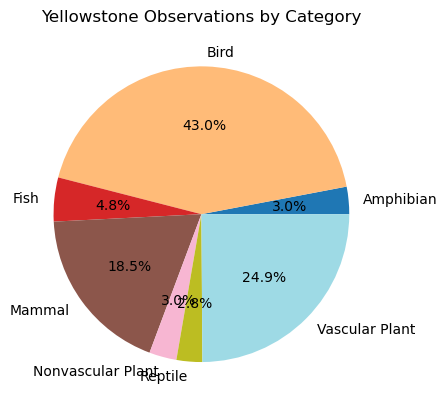

In [64]:
yellowstone_observations_by_category.plot(kind='pie', title='Yellowstone Observations by Category', ylabel='', autopct='%1.1f%%', colormap='tab20')

<Axes: title={'center': 'Yosemite Observations by Category'}>

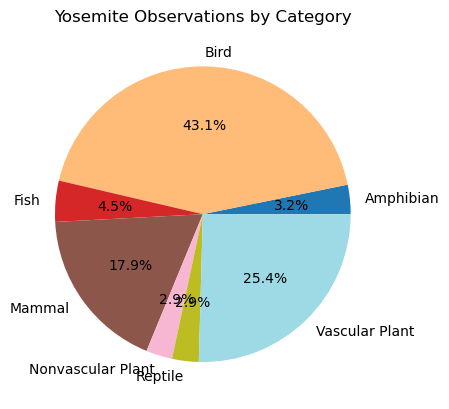

In [65]:
yosemite_observations_by_category.plot(kind='pie', title='Yosemite Observations by Category', ylabel='', autopct='%1.1f%%', colormap='tab20')

<Axes: title={'center': 'Great Smoky Mountains Observations by Category'}>

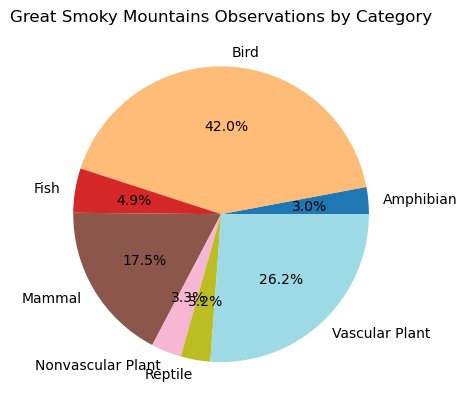

In [66]:
smoky_observations_by_category.plot(kind='pie', title="Great Smoky Mountains Observations by Category", ylabel='', autopct='%1.1f%%', colormap='tab20')

<Axes: title={'center': 'Observations by Category'}>

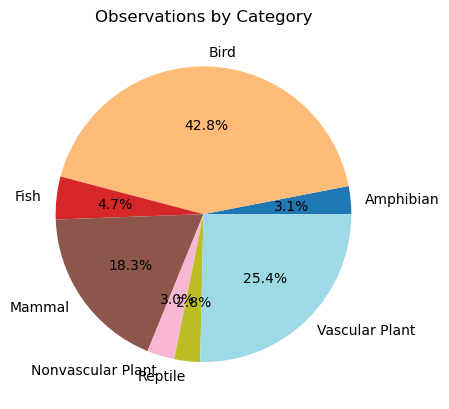

In [67]:
all_observations_by_category = final_table.groupby('category').total_observations.sum()
all_observations_by_category.plot(kind='pie', title='Observations by Category', ylabel='', autopct='%1.1f%%', colormap='tab20')

([<matplotlib.patches.Wedge at 0x21661c1dcd0>,
 [Text(0.927864513944281, 0.5908192987394227, 'Bryce'),
  Text(0.04796221115717308, 1.0989538781499955, 'Great Smoky Mountains'),
  Text(-1.012836799734314, 0.4291405563494941, 'Yosemite'),
  Text(0.2291453729524614, -1.0758682066380052, 'Yellowstone')],
 [Text(0.5061079166968805, 0.32226507203968513, '18.0%'),
  Text(0.026161206085730766, 0.5994293880818156, '12.5%'),
  Text(-0.5524564362187167, 0.23407666709972402, '26.1%'),
  Text(0.12498838524679712, -0.5868372036207301, '43.3%')])

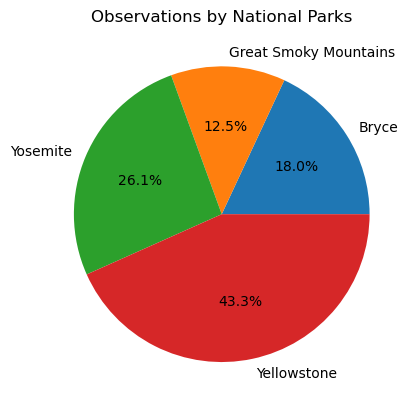

In [69]:
bryce = final_table.Bryce.sum()
smoky = final_table.Smoky.sum()
yosemite = final_table.Yosemite.sum()
yellowstone = final_table.Yellowstone.sum()
observations_by_park = [bryce, smoky, yosemite, yellowstone]
labels = ['Bryce', 'Great Smoky Mountains', 'Yosemite', 'Yellowstone']
fig, ax = plt.subplots()
ax.set_title('Observations by National Parks')
ax.pie(observations_by_park, labels=labels, autopct='%1.1f%%')